<a href="https://colab.research.google.com/github/valievav/ML-projects/blob/main/CNN_MobileNetV2_90_animals_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
from io import BytesIO

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Prepare & investigate data

In [2]:
# get data from kaggle
# https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/code?datasetId=1554380&sortBy=voteCount
root_path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

# path to the animals images folder
path = os.path.join(root_path, "animals", "animals")


In [3]:
# prepare general df with all the data for further split
category = os.listdir(path)
print(category)

data = {"imgpath": [] , "labels": [] }
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)

df = pd.DataFrame(data)
df.head(5)


['hippopotamus', 'bear', 'tiger', 'goldfish', 'gorilla', 'cat', 'porcupine', 'grasshopper', 'orangutan', 'starfish', 'squid', 'possum', 'wolf', 'raccoon', 'turkey', 'koala', 'badger', 'boar', 'hummingbird', 'duck', 'ox', 'lobster', 'whale', 'bat', 'hyena', 'otter', 'owl', 'dog', 'mosquito', 'leopard', 'antelope', 'fly', 'pelecaniformes', 'lizard', 'snake', 'donkey', 'rat', 'sandpiper', 'chimpanzee', 'dolphin', 'elephant', 'moth', 'bison', 'crow', 'fox', 'wombat', 'parrot', 'cow', 'seahorse', 'caterpillar', 'goat', 'pigeon', 'beetle', 'dragonfly', 'flamingo', 'shark', 'sheep', 'eagle', 'squirrel', 'horse', 'ladybugs', 'goose', 'octopus', 'hare', 'rhinoceros', 'reindeer', 'oyster', 'sparrow', 'panda', 'hedgehog', 'turtle', 'mouse', 'butterfly', 'woodpecker', 'lion', 'hamster', 'jellyfish', 'penguin', 'bee', 'pig', 'swan', 'zebra', 'coyote', 'deer', 'okapi', 'cockroach', 'kangaroo', 'seal', 'crab', 'hornbill']


,imgpath,labels
0,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus
1,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus
2,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus
3,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus
4,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus


In [4]:
# add column with encoded labels
lb = LabelEncoder()

df['encoded_labels'] = lb.fit_transform(df['labels'])
df.head(5)


,imgpath,labels,encoded_labels
0,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus,36
1,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus,36
2,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus,36
3,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus,36
4,/root/.cache/kagglehub/datasets/iamsouravbaner...,hippopotamus,36


In [52]:
# prepare label/class lookup
class_mapping = dict(zip(lb.transform(lb.classes_), lb.classes_))
class_mapping


{0: 'antelope',
 1: 'badger',
 2: 'bat',
 3: 'bear',
 4: 'bee',
 5: 'beetle',
 6: 'bison',
 7: 'boar',
 8: 'butterfly',
 9: 'cat',
 10: 'caterpillar',
 11: 'chimpanzee',
 12: 'cockroach',
 13: 'cow',
 14: 'coyote',
 15: 'crab',
 16: 'crow',
 17: 'deer',
 18: 'dog',
 19: 'dolphin',
 20: 'donkey',
 21: 'dragonfly',
 22: 'duck',
 23: 'eagle',
 24: 'elephant',
 25: 'flamingo',
 26: 'fly',
 27: 'fox',
 28: 'goat',
 29: 'goldfish',
 30: 'goose',
 31: 'gorilla',
 32: 'grasshopper',
 33: 'hamster',
 34: 'hare',
 35: 'hedgehog',
 36: 'hippopotamus',
 37: 'hornbill',
 38: 'horse',
 39: 'hummingbird',
 40: 'hyena',
 41: 'jellyfish',
 42: 'kangaroo',
 43: 'koala',
 44: 'ladybugs',
 45: 'leopard',
 46: 'lion',
 47: 'lizard',
 48: 'lobster',
 49: 'mosquito',
 50: 'moth',
 51: 'mouse',
 52: 'octopus',
 53: 'okapi',
 54: 'orangutan',
 55: 'otter',
 56: 'owl',
 57: 'ox',
 58: 'oyster',
 59: 'panda',
 60: 'parrot',
 61: 'pelecaniformes',
 62: 'penguin',
 63: 'pig',
 64: 'pigeon',
 65: 'porcupine',
 66: 

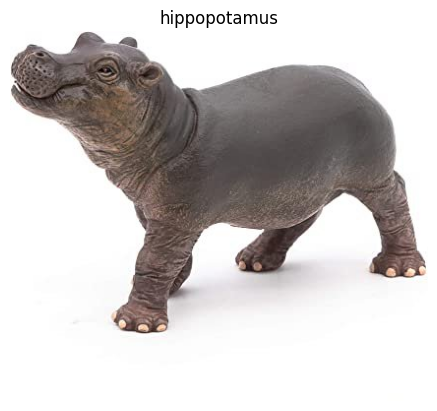

In [6]:
# visualize 1st image
index = 0
img = Image.open(df['imgpath'][index])
plt.imshow(img)
plt.title(df["labels"][index])
plt.axis('off')
plt.show()

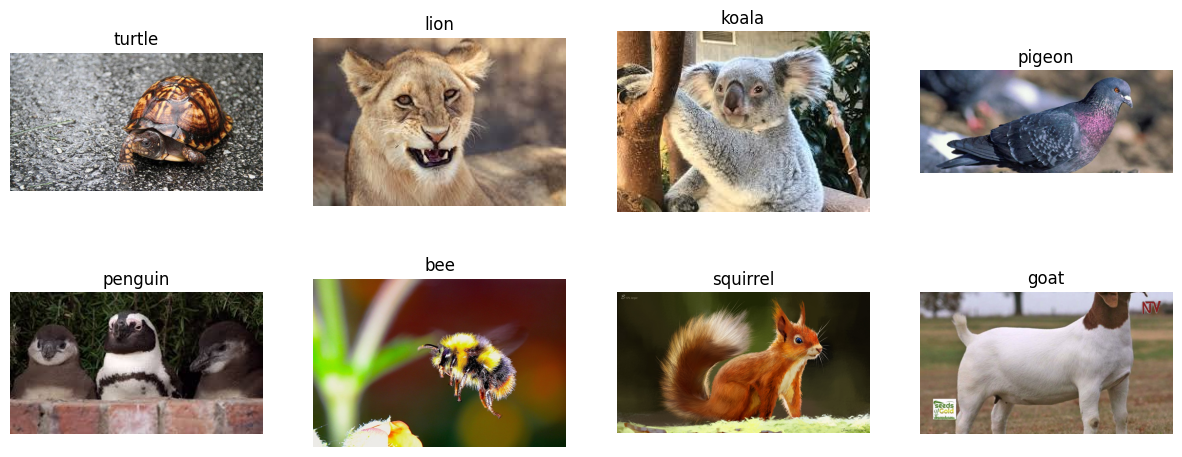

In [7]:
# visualize 8 random images
n = 8
plt.figure(figsize=(15,12))
for i, row in df.sample(n=8).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()


# Split Data into Train, Valid & Test

In [8]:
# split into 3 df
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)

# remove old index columns
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

train_df.head(5)

(3779, 3)
(1134, 3)
(487, 3)


,imgpath,labels,encoded_labels
0,/root/.cache/kagglehub/datasets/iamsouravbaner...,sheep,75
1,/root/.cache/kagglehub/datasets/iamsouravbaner...,squid,78
2,/root/.cache/kagglehub/datasets/iamsouravbaner...,rat,68
3,/root/.cache/kagglehub/datasets/iamsouravbaner...,gorilla,31
4,/root/.cache/kagglehub/datasets/iamsouravbaner...,snake,76


In [9]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
SEED = 123  # for reproducibility

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255,  # normalize pixel values to [0, 1]
)

# split the data into 3 categories
train_ds = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='sparse',  # labels are not one-hot incoded, else categorical
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

test_ds = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)


Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.


# Create and train model

In [11]:
# use MobileNetV2 (light-wight model, pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')

# freeze base model
base_model.trainable = False

# build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(train_ds.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # since labels are not one-hot encoded, else categorical_crossentropy
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,609,050 (9.95 MB)

 Trainable params: 351,066 (1.34 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.3778 - loss: 2.9494 - val_accuracy: 0.7628 - val_loss: 0.9304
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 221s 930ms/step - accuracy: 0.8933 - loss: 0.3988 - val_accuracy: 0.7875 - val_loss: 0.7851
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9686 - loss: 0.1370 - val_accuracy: 0.8307 - val_loss: 0.6395
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 289s 978ms/step - accuracy: 0.9846 - loss: 0.0724 - val_accuracy: 0.8360 - val_loss: 0.6320
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 234s 988ms/step - accuracy: 0.9981 - loss: 0.0285 - val_accuracy: 0.8510 - val_loss: 0.5534


In [67]:
# evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - accuracy: 0.8561 - loss: 0.5730
Test loss: 0.5811397433280945, Test accuracy: 0.8521560430526733


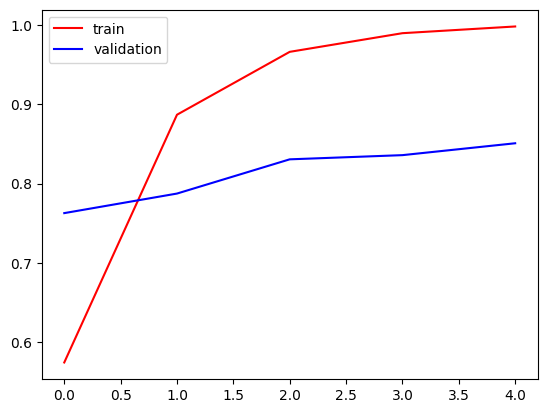

In [61]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


In [66]:
# save model for future use
model_name = 'MobileNetV2_based_model.keras'
model.save(model_name)

# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_name)


# Check model predictions on unseen data

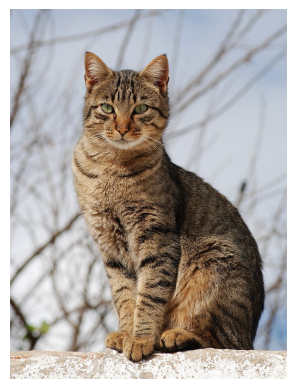

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: [9]
Predicted label: cat. CORRECT? True


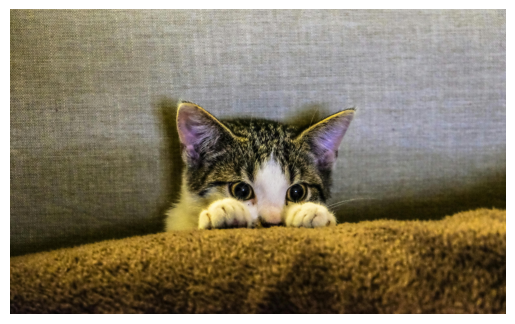

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class: [9]
Predicted label: cat. CORRECT? True


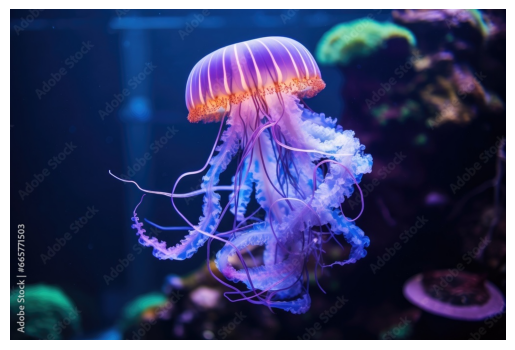

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: [41]
Predicted label: jellyfish. CORRECT? True


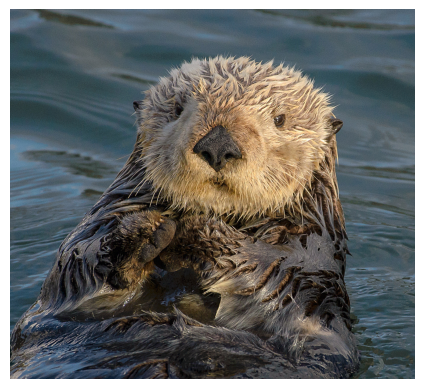

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted class: [55]
Predicted label: otter. CORRECT? True


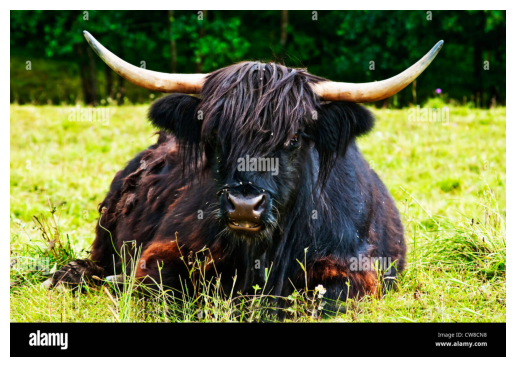

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted class: [57]
Predicted label: ox. CORRECT? True


In [58]:
url_mapping = {
    'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg': 'cat',
    'https://images.pexels.com/photos/96938/pexels-photo-96938.jpeg': 'cat',
    'https://as2.ftcdn.net/v2/jpg/06/65/77/15/1000_F_665771503_IugD47zc2ojqj7jrtVDNn5cusVEAr3LM.jpg': 'jellyfish',
    'https://upload.wikimedia.org/wikipedia/commons/0/02/Sea_Otter_%28Enhydra_lutris%29_%2825169790524%29_crop.jpg': 'otter',
    'https://c7.alamy.com/comp/CW8CN8/scottish-highland-ox-CW8CN8.jpg': 'ox',
}

for url, actual_label in url_mapping.items():
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))

  # show the image
  plt.imshow(img)
  plt.axis('off')  # hide axes
  plt.show()

  # preprocess the image for model
  img = img.resize(IMG_SIZE)  # resize to match model input size
  img_array = image.img_to_array(img)  # convert image to array (height, width, channels)
  img_array = np.expand_dims(img_array, axis=0)  # add batch dimension (1, height, width, channels)
  img_array = img_array / 255.0  # Normalize (0-1 range)
  print(img_array.shape)  # Should be (1, 224, 224, 3)

  # get predictions
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions, axis=-1) # get the class with highest probability
  print(f"Predicted class: {predicted_class}")

  predicted_label = class_mapping[predicted_class[0]]
  correct = predicted_label == actual_label
  print(f"Predicted label: {predicted_label}. CORRECT? {correct}")


In [73]:
from sklearn.metrics import classification_report, f1_score

y_true = test_ds.classes
y_pred = np.argmax(model.predict(test_ds), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)


31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 911ms/step
F1 Score: 0.013283475783475784
